In [11]:
import math
from itertools import combinations, groupby
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np

import numpy as np
import pickle

In [12]:
G = pickle.load(open("../src/dashboard/data/graph.pkl", "rb"))

FileNotFoundError: [Errno 2] No such file or directory: '../src/dashboard/data/graph.pkl'

In [ ]:
"""
p1, p2 -> (lng, lat)

Formula
a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
c = 2 ⋅ atan2( √a, √(1−a) )
d = R ⋅ c
"""
def get_distance(p1, p2):
    r = 6371e3
    phi_1 = p1[1] * math.pi / 180
    phi_2 = p2[1] * math.pi / 180
    delta_phi = (p1[1] - p2[1]) * math.pi / 180
    delta_lambda = (p2[0] - p1[0]) * math.pi / 180

    a = math.sin(delta_phi / 2) ** 2
    a += math.cos(phi_1) * math.cos(phi_2) * (math.sin(delta_lambda / 2) ** 2)

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return r * c


assert int(get_distance((52, 16), (50, 18))) == 307702
assert int(get_distance((16.794616, 52.694275), (16.798850, 52.686101))) == 952

In [ ]:
points = []
point_indexes = {}

for node in G.nodes():
    point_indexes[node] = len(points)
    points.append(node)

nodes = len(points)

connections = np.zeros((nodes, nodes), dtype=bool)

for edge in G.edges():
    start, end = point_indexes[edge[0]], point_indexes[edge[1]]

    connections[start, end] = True
    connections[end, start] = True

points = np.array(points)

distances = np.zeros((nodes, nodes), dtype=float)

for i in range(nodes):
    for j in range(i + 1, nodes):
        distance = get_distance(points[i], points[j])
        distances[i, j] = distance
        distances[j, i] = distance

In [ ]:
class PathFinder:
    def __init__(self, p, c, d, target=3000, s=0, precision=100):
        self.points = p
        self.connections = c
        self.distances = d
        self.target = target
        self.start = s
        self.precision = precision

        self.best_solution = None
        self.best_abs_distance = None

    def get_closest_path(self):
        solution = [self.start]
        edges_used = {}
        nodes_used = {}
        current_distance = 0

        for p in range(len(self.points)):
            nodes_used[p] = 0

        nodes_used[self.start] += 1

        self.best_solution = None
        self.best_abs_distance = None

        self.get_closest_path_recursive(solution, edges_used, nodes_used, current_distance)

        return self.best_solution

    def get_closest_path_recursive(self, solution, edges_used, nodes_used, current_distance):
        current_edge = solution[-1]

        if self.best_abs_distance is not None and self.best_abs_distance < self.precision:
            return

        if current_edge == self.start and len(solution) > 1:

            abs_distance = abs(self.target - current_distance)

            if self.best_abs_distance is None or abs_distance < self.best_abs_distance:
                self.best_abs_distance = abs_distance
                self.best_solution = solution.copy()

            return

        closest_edges = list(np.where(self.connections[current_edge, :])[0])
        closest_edges.sort(key=lambda x: (edges_used.get(x, 0), nodes_used.get(x, 0)))

        for closest_edge in closest_edges:
            edge_representation = self.get_edge_representation(current_edge, closest_edge)

            used_count = edges_used.get(edge_representation, 0)

            if used_count >= 2:
                continue

            new_distance = current_distance + self.distances[current_edge][closest_edge]
            min_distance = new_distance + self.distances[closest_edge][self.start]

            if self.best_abs_distance is not None and min_distance - self.target > self.best_abs_distance:
                continue

            edges_used[edge_representation] = used_count + 1
            nodes_used[closest_edge] += 1
            solution.append(closest_edge)

            self.get_closest_path_recursive(solution, edges_used, nodes_used, new_distance)

            del solution[-1]
            edges_used[edge_representation] -= 1
            nodes_used[closest_edge] -= 1

    @staticmethod
    def get_edge_representation(p1, p2):
        if p1 > p2:
            return p1, p2
        else:
            return p2, p1


finder = PathFinder(points, connections, distances)
finder.get_closest_path()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 797,
 798,
 799,
 800,
 801,
 802,
 803,
 802,
 801,
 800,
 799,
 798,
 797,
 6,
 5,
 4,
 3,
 2,
 1,
 796,
 795,
 796,
 1,
 0]

In [ ]:
finder = PathFinder(points, connections, distances, s=500, target=5000)
path = finder.get_closest_path()

In [ ]:
path

[500,
 499,
 498,
 497,
 496,
 495,
 567,
 568,
 569,
 540,
 539,
 538,
 537,
 536,
 535,
 534,
 533,
 532,
 531,
 530,
 529,
 528,
 527,
 526,
 525,
 524,
 523,
 522,
 521,
 520,
 519,
 518,
 517,
 516,
 515,
 514,
 513,
 512,
 511,
 510,
 509,
 508,
 507,
 506,
 505,
 504,
 503,
 502,
 501,
 502,
 503,
 504,
 505,
 506,
 507,
 508,
 509,
 510,
 511,
 512,
 513,
 514,
 515,
 935,
 568,
 567,
 1275,
 1276,
 1275,
 567,
 495,
 496,
 497,
 498,
 499,
 500]

In [ ]:
def get_paths_distance(p, d):
    dis = 0

    for point in range(len(p) - 1):
        dis += d[p[point]][p[point + 1]]

    return dis

get_paths_distance(path, distances)

5012.789945194361

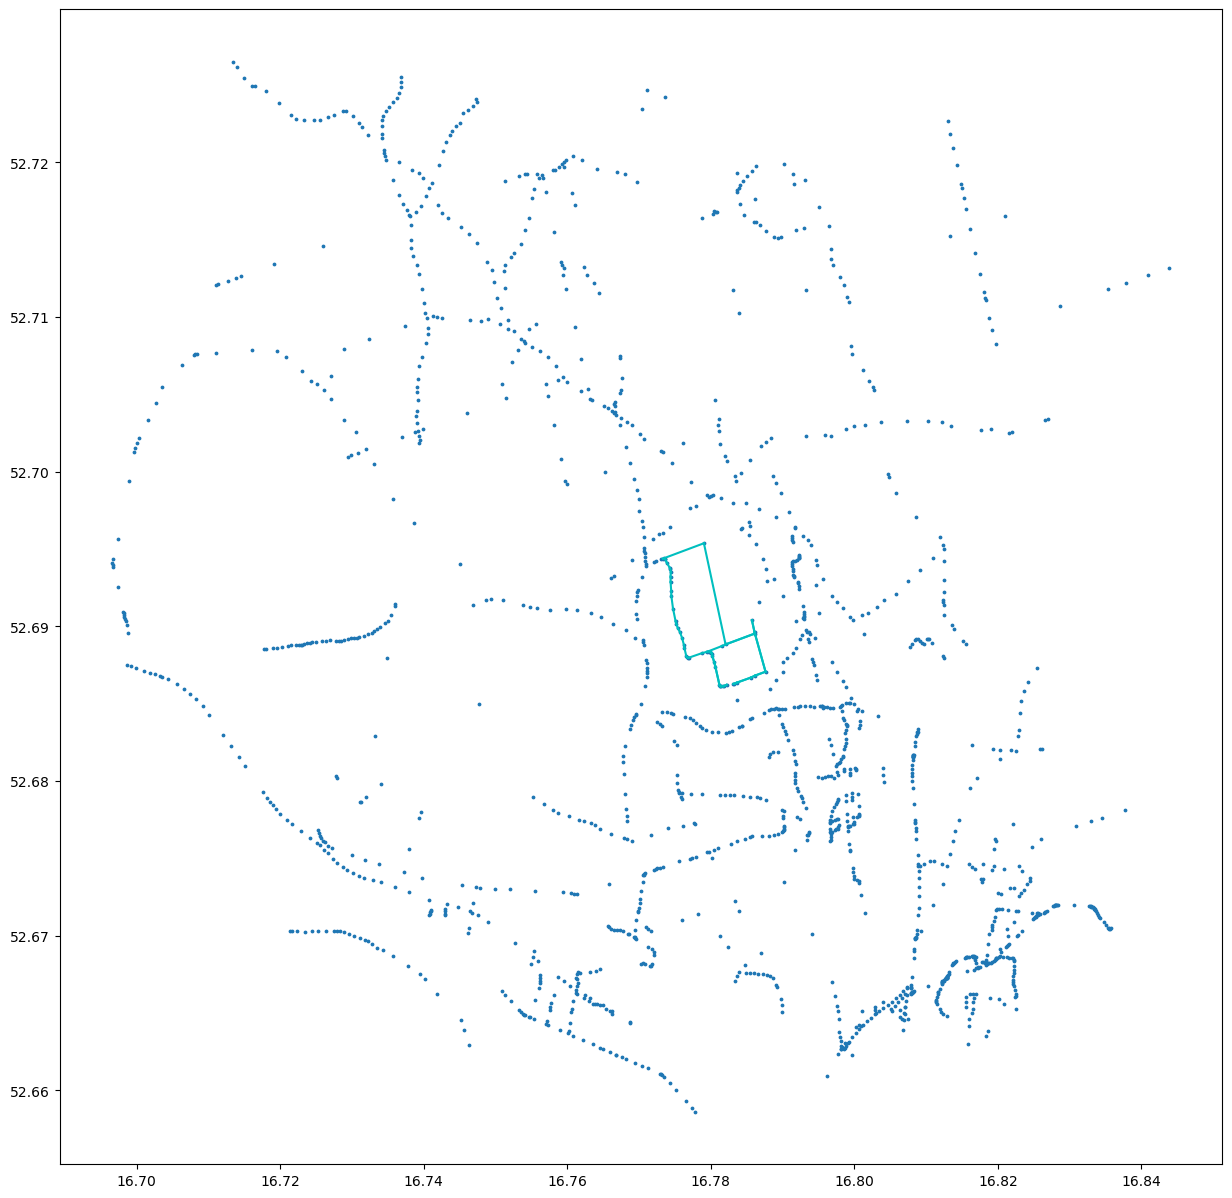

In [159]:
plt.figure(figsize=(15, 15))
plt.scatter(points[:, 0], points[:, 1], s=3)

for i in range(len(path) - 1):
    p1, p2 = path[i], path[i + 1]
    assert connections[p1][p2]
    plt.plot([points[p1, 0], points[p2, 0]], [points[p1, 1], points[p2, 1]], c='c')